## Dati Satellite Sentinel-2 (multispectral bands)

In [1]:
from path import Path
import arrow
import json
import pytz
from pprint import pprint
from tqdm.notebook import tqdm
import re, os, collections, itertools, uuid, logging
import tempfile
import shapely

import zipfile
import urllib

import ee
import pyproj
import numpy as np
import scipy as sp
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (15, 5) # bigger plots
plt.style.use('fivethirtyeight')
%matplotlib inline
%precision 4

'%.4f'

In [2]:
helper_dir = str(Path('..').abspath())
if helper_dir not in os.sys.path:
    os.sys.path.append(helper_dir)
    
from leak_helpers.earth_engine import display_ee, get_boundary, tifs2np, bands_s2, download_image

In [3]:
# # Non voglio stampare i Warning
# import warnings
# warnings.filterwarnings("ignore")

# Load leaks

Load the leaks from a geojson file and make sure they have unique fields reportdate and workorderid (see asserts below)

In [4]:
# load 
root = "C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite"
leaks = gpd.read_file(root+"/data/leak_dataset/leaks.geojson")

leaks_datas = [leaks]

leaks_datas

[          id  anno civico       comune  \
 0          0  2015    137        AULLA   
 1          1  2015      8        AULLA   
 2          2  2015    110        AULLA   
 3          3  2015    snc        aulla   
 4          4  2015    snc        aulla   
 ...      ...   ...    ...          ...   
 33179  33179  2021   None  GIUNCUGNANO   
 33180  33180  2021   None    MOLAZZANA   
 33181  33181  2021   None    MASSAROSA   
 33182  33182  2021   None    MASSAROSA   
 33183  33183  2021   None    MASSAROSA   
 
                                              description  diametro  \
 0                               Perdita acqua dalla rete      63.0   
 1                               Perdita acqua dalla rete      40.0   
 2                               Perdita acqua dalla rete      90.0   
 3      perdita rete idrica su strada provinciale in l...      90.0   
 4       perdita rete idrica in loc albiano via molinetti      63.0   
 ...                                                  ..

In [5]:
# join them all, with primary columns and random metadata
primary_cols = ['workorderid','reportdate','geometry']
leaks = gpd.GeoDataFrame(pd.concat([leaks_data[primary_cols] for leaks_data in leaks_datas]), crs='epsg:4326')
leaks['metadata'] = np.concatenate([leaks_data.drop(primary_cols,1).to_dict('records') for leaks_data in leaks_datas])
leaks.index = leaks.workorderid
leaks

C:\Users\TRANFA~1.CAR\AppData\Local\Temp/ipykernel_8900/3025104378.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  leaks['metadata'] = np.concatenate([leaks_data.drop(primary_cols,1).to_dict('records') for leaks_data in leaks_datas])


,workorderid,reportdate,geometry,metadata
workorderid,,,,
430398,430398,2015-05-08T08:16:00+00:00,POINT (9.90141 44.17144),"{'id': '0', 'anno': 2015, 'civico': '137', 'co..."
454859,454859,2015-06-10T08:18:00+00:00,POINT (9.91343 44.17462),"{'id': '1', 'anno': 2015, 'civico': '8', 'comu..."
455210,455210,2015-06-11T09:09:00+00:00,POINT (9.90498 44.17221),"{'id': '2', 'anno': 2015, 'civico': '110', 'co..."
459545,459545,2015-06-18T06:00:56.737000+00:00,POINT (9.90778 44.17321),"{'id': '3', 'anno': 2015, 'civico': 'snc', 'co..."
467973,467973,2015-06-30T06:10:52.959999+00:00,POINT (9.91327 44.17462),"{'id': '4', 'anno': 2015, 'civico': 'snc', 'co..."
...,...,...,...,...
2725108,2725108,2021-10-21T14:50:35.837002+00:00,POINT (10.23105 44.20313),"{'id': '33179', 'anno': 2021, 'civico': None, ..."
2730580,2730580,2021-10-26T11:23:17.657000+00:00,POINT (10.41085 44.08091),"{'id': '33180', 'anno': 2021, 'civico': None, ..."
2746652,2746652,2021-11-08T15:39:00+00:00,POINT (10.36244 43.84858),"{'id': '33181', 'anno': 2021, 'civico': None, ..."


In [6]:
# limit leaks to the time and space where satellite data exists
print('before',len(leaks))

# limit it to after satelite came into service
leaks= leaks[pd.to_datetime(leaks.reportdate)>pd.Timestamp('2014-10-03', tz='UTC')] 

# # also limit them by location
# satellite_bounds = shapely.geometry.box(
#     # continentental us
#     minx = -124.7844079, # west long
#     miny =  24.7433195, # south lat
#     maxx = -66.9513812, # east long
#     maxy = 49.3457868, # north lat   
# )
# leaks = leaks[leaks.intersects(satellite_bounds)]
print('after',len(leaks))

before 33184
after 33183


## Params

Customise the values in the cell below

In [7]:
# params
bands = bands_s2
satellite = 'COPERNICUS/S2'
resolution_min = 10.0 # m
cloudy_percentage = 30

# since the lowest res band is 60m and I want to capture neighbours I should get 6+ pixels
pixel_length = 25.0

# you need to tweak this until you pass the "Test the distance need to get your rectangle" cell
fudge_distance_factor = -0.5

## Init

In [10]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "notebook_name = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [11]:
#notebook_name='scraping_earth_engine_s2'
notebook_name

'scraping_earth_engine_s2'

In [12]:
# constant params, probobly don't change
#time_bin_delta = 60*60*6 # how long before a leak to look (in seconds)
time_before = 6*60*60
time_after = 21*24*60*60
crs_grid = 3857 # keep this as auxilary sphere, this is the CRS the downloaded images will be in

# init
## init directories
ts=arrow.utcnow().format('YYYYMMDD-HH-mm-ss')
temp_dir = Path(root+'/data/scraped_satellite_images/'+satellite.replace("/","_")+'/tmp/')
output_dir = Path(root+'/data/scraped_satellite_images/'+satellite.replace("/","_"))
cache_dir = Path(output_dir+'/cache')
output_dir.makedirs_p()
temp_dir.makedirs_p()
cache_dir.makedirs_p()

## init logger
logger = logging.getLogger(notebook_name)
# logger.setLevel(logging.WARN)

temp_dir, output_dir, cache_dir

(Path('C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/tmp/'),
 Path('C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2'),
 Path('C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache'))

In [13]:
# record cofig in a json file
metadata = dict(
    notebook_name=notebook_name,
    satellite=satellite,
    #time_bin_delta=time_bin_delta,
    time_before=time_before,
    time_after=time_after,
    cloudy_percentage=cloudy_percentage,
    pixel_length=pixel_length,
    resolution_min=resolution_min,
    bands=bands,
    ts=ts,
    crs_grid=crs_grid,
    cache_dir=str(cache_dir),
    temp_dir=str(temp_dir),
    output_dir=str(output_dir),
)
metadata_file = output_dir.joinpath('script_metadata.json')
json.dump(metadata, open(metadata_file,'w'))

# Earth Engine

Setup instructions here
- first need to apply for an account and wait ~ 1day
- https://developers.google.com/earth-engine/python_install#setting-up-authentication-credentials

Refs:
- api https://developers.google.com/earth-engine/
- code examples https://code.earthengine.google.com/
- sentinel1 https://developers.google.com/earth-engine/sentinel1
    - `ee.ImageCollection('COPERNICUS/S2_GRD');`
    - `ee.ImageCollection('COPERNICUS/S1_GRD');`
- keras and google earth https://github.com/patrick-dd/landsat-landstats

In [14]:
# test earth-engine setup
from oauth2client import crypt # should have not error
import ee
ee.Initialize() # should give no errors, if so follow instructions

# test
image = ee.Image(ee.ImageCollection(satellite).first())
info = image.getInfo()
info

{'type': 'Image',
 'bands': [{'id': 'B1',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [1830, 1830],
   'crs': 'EPSG:32631',
   'crs_transform': [60, 0, 300000, 0, -60, 3100020]},
  {'id': 'B2',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [10980, 10980],
   'crs': 'EPSG:32631',
   'crs_transform': [10, 0, 300000, 0, -10, 3100020]},
  {'id': 'B3',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [10980, 10980],
   'crs': 'EPSG:32631',
   'crs_transform': [10, 0, 300000, 0, -10, 3100020]},
  {'id': 'B4',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [10980, 10980],
   'crs': 'EPSG:32631',
   'crs_transform': [10, 0, 300000, 0, -10, 3100020]},
  {'id': 'B5',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min':

# Fetching images

For a leak repair, grab the image before and after it

Note roughly 10% have results for a 1 day temporal bin
For each point
- find the nearest image before the repair
- and the soonest image after repair
- save a part of each with metadata

Later we can filter, interpolate, and read into numpy arrays

In [15]:
import dataset
cache_file = 'sqlite:///{}'.format(cache_dir.dirname().joinpath('cache.db'))
db = dataset.connect(cache_file)
cache_table = db.get_table('cached_ids', primary_id='workorderid')

def get_cached_ids():
    return set(row['workorderid'] for row in cache_table.distinct('workorderid'))

def init_cache(workorderid):
    """We will cache downloads in folders like 'id_after'"""
    if workorderid:
        try:
            cache_table.insert(dict(workorderid=workorderid))
        except:
            db.rollback()
        else:
            db.commit()
    return

#Aggiunge il workorderid per il quale ho già l'immagine
img_path = Path('../../data/scraped_satellite_images/'+satellite.replace("/","_")+'/cache/')
for i in os.listdir(img_path):
    init_cache(i.split('_')[0])

# Conta il set di workorderid già scaricati
len(get_cached_ids())

33183

In [16]:
# # # Cancella dati dalla tabella
#cache_table.delete()

# Conta il set di workorderid che mancano da provare a scaricare
leak_to_scrape = set(leaks.workorderid).difference(set(get_cached_ids()))

len(leak_to_scrape)
#leak_to_scrape

0

### Test the distance need to get your rectangle

Here we need to tweak `fudge_distance_factor` so that we get the image size of our choice. Start with zero and try -1, -0.5, -.25,0,0.25,0.5,0.75. This is to deal with rounding, projecting between CRS's etc. Don't worry the asserts below will yet you know when it's right.

Occasionaly the problem might be that the leak is at the edge of the image, giving a cropped image. Ignore these rare cases.

In [17]:
distance = resolution_min*(pixel_length/2.00+fudge_distance_factor)

In [18]:
import time
import traceback
cached_ids = get_cached_ids()


def get_image_for_leak(i, cached_ids=cached_ids):
    leak = leaks.loc[[i]]
    repo_date_ts = arrow.get(leak.reportdate.values[0]).timestamp()
    
    # crappy way or recording that we tried this one
    workorderid = leak.workorderid.values[0]
    if workorderid in cached_ids:
        logger.info('Skipping cached download for leak id %s ',workorderid)
        return
    
    boundary = get_boundary(leak, distance=distance)
    
    # get image day before    
    sentinel2_before = (ee.ImageCollection(satellite)
                        .filterBounds(boundary)
                        .filterDate((repo_date_ts-time_before)*1000,(repo_date_ts+time_before)*1000)
                        .filterMetadata('CLOUDY_PIXEL_PERCENTAGE','less_than',cloudy_percentage)
                        .sort('system:time_start', opt_ascending=False) # first will be latest
                       )
    
    results = sentinel2_before.size().getInfo()
    if results<1:
        logger.info('Error no results for day before %s',workorderid)
        cached_ids = init_cache(str(workorderid)) # so we know there where no results
        return
        
    # get image day after
    sentinel2_after = (ee.ImageCollection(satellite)
                       .filterBounds(boundary)
                       .filterDate((repo_date_ts+time_after)*1000,(repo_date_ts+time_after*2)*1000)
                       .filterMetadata('CLOUDY_PIXEL_PERCENTAGE','less_than',cloudy_percentage)
                       .sort('system:time_start', opt_ascending=True) # first will be earliest
                      )
        
    results = sentinel2_after.size().getInfo()
    if results<1:
        logger.info('Error no results for day after, id %s',workorderid)
        cached_ids = init_cache(str(workorderid)) # so we know there where no results
        return
        
    # download as save images    
    logger.info('results for %s', workorderid)
    image = ee.Image(sentinel2_before.first()).clip(boundary)
    name=str(workorderid)+'_before'
    path,files=download_image(
        image, 
        scale=resolution_min, 
        crs=crs_grid, 
        name=name,
        cache_dir=cache_dir
    )
    # also save metadata so we can filter by date
    with open(path.joinpath('metadata.json'), 'w') as fo:
        metadata = dict(
            image=image.getInfo(),
            scale=resolution_min,
            crs=crs_grid,
            name=name,
            distance=distance,
            leak=json.loads(leak.to_json())
        )
        json.dump(metadata, fo)

    image = ee.Image(sentinel2_after.first()).clip(boundary)
    name=str(workorderid)+'_after'
    path,files=download_image(
        image, 
        scale=resolution_min, 
        crs=crs_grid, 
        name=name,
        cache_dir=cache_dir
    )
    with open(path.joinpath('metadata.json'), 'w') as fo:
        metadata = dict(
            image=image.getInfo(),
            scale=resolution_min,
            crs=crs_grid,
            name=name,
            distance=distance,
            leak=json.loads(leak.to_json())
        )
        json.dump(metadata, fo)
    cached_ids = init_cache(str(workorderid)) # so we know there where results
    return

leak_to_scrape = set(leaks.workorderid).difference(set(cached_ids))
for i in tqdm(leak_to_scrape):
    try:
        get_image_for_leak(i)
    except urllib.error.HTTPError as e:
        print(i,e) # "HTTP Error 429: unknown"
        traceback.print_stack()
        if e.code == 429:
            print('sleep for 13s')
            time.sleep(13);
    except ee.ee_exception.EEException as e:
        print(i,e) # "Earth Engine memory capacity exceeded."
        traceback.print_stack()
        ee.Initialize()
    except zipfile.BadZipFile as e:
        print(i,e) # "File is not a zip file"
        traceback.print_stack()
    except Exception as e:
        print(i,e)
        traceback.print_stack()

0it [00:00, ?it/s]

# Load Tiffs to Arrays

In [19]:
# This loads it as X and y for machine learning, and also time and metadata so we can filter
import shapely
X = []
y = []
t = []
m = []
discarded=[]
for path in tqdm(cache_dir.listdir()):
    files = [file.relpath(path) for file in path.listdir() if file.endswith('.tif')]
    if files:
        # check metadata
        try:
            metadata = json.load(open(path.joinpath('metadata.json')))
        except (FileNotFoundError, ValueError) as e:
            path.move(path.replace(path.basename(),'.deleteme-'+str(uuid.uuid4())))
            if '_after_' in path: # also delete the before path                
                path_after = Path(path.replace('_after_','_before_'))
                if path_after.isdir():
                    path_after.move(path.replace(path.basename(),'.deleteme-'+str(uuid.uuid4())))
            logger.error('Invalid metadata.json, deleted folder %s, please rerun scraping cell to rescrape this image', path)
            continue
        
        # e.g. lets filter it so "before" image are only 1 day before
        if '_before_' in path.basename():
            yy = True
        else:
            yy = False
        
        # work out time gap too
        t1 = arrow.get(metadata['image']['properties']['system:time_end']/1000)
        t0 = arrow.get(metadata['leak']['features'][0]['properties']['reportdate'])
        td=t1-t0
        tt = td.total_seconds()
        
        # load data
        data = tifs2np(path,files,bands=bands)
             
        # check we don't have empty bands 1-13
        empty_bands = np.array([d.sum() for d in data])==0
        
        # lets check we didn't get the edge of an image
        bbox = np.array(metadata['image']['properties']['system:footprint']['coordinates'][0])
        loc = metadata['leak']['features'][0]['geometry']['coordinates']
        minx=bbox[:,0].min()
        maxx=bbox[:,0].max()
        miny=bbox[:,1].min()
        maxy=bbox[:,1].max()
        bbox_shp = shapely.geometry.box(
            minx=minx,
            maxx=maxx,
            miny=miny,
            maxy=maxy
        )
        loc_shp = shapely.geometry.Point(loc[0],loc[1])
        shapely.geometry.GeometryCollection([bbox_shp, loc_shp])
        try:
            print(data.shape)
            assert loc_shp.intersects(bbox_shp), 'leak location should be inside image'
            assert bbox_shp.centroid.almost_equals(loc_shp, decimal=5), 'leak should be near center of image'
            assert (np.array([d.shape for d in data])==pixel_length).all(), 'image area should be the right amount of pixels'
            #assert (maxx-minx)/(maxy-miny)<1.3, 'should be roughly square'
            #assert (maxx-minx)/(maxy-miny)>0.7, 'should be roughly square'
            assert not empty_bands.all(), 'should not have all bands empty'
            assert sum([ c for c in ((data[bands.index('QA60')]/1024).astype(dtype="uint16")).flatten() ])/len(data[bands.index('QA60')].flatten()) < 0.05, 'image area è troppo nuvolosa'
            assert sum([ c for c in ((data[bands.index('B10')]/10 -1 ).astype(dtype="uint16")).flatten() ])/len(data[bands.index('B10')].flatten()) < 0.15, 'image area è troppo nuvolosa'
        except Exception as exc:
            print(path, exc)
#             raise(exc)
            discarded.append(path)
        else:
            X.append(data)
            y.append(yy)
            t.append(tt)
            m.append(metadata)
        

len(X), len(discarded)

  0%|          | 0/12171 [00:00<?, ?it/s]

(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1000250_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)


C:\Users\TRANFA~1.CAR\AppData\Local\Temp/ipykernel_8900/399882260.py:59: ShapelyDeprecationWarning: The 'almost_equals()' method is deprecated and will be removed in Shapely 2.0
  assert bbox_shp.centroid.almost_equals(loc_shp, decimal=5), 'leak should be near center of image'


(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1010375_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1010404_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1010923_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1010945_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1010960_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tr

C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1040409_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1040422_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1044542_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1044580_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1046161_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25,

(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1116435_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1116435_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 22, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1116444_after_3857_10.0 leak should be near center of image
(14, 22, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1116444_before_3857_10.0 leak should be near center of image
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa

(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1132953_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1132963_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1137245_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1137994_before_3857_10.0 image

(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1146692_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1146692_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1146742_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1146742_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1146762_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/

C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1160452_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1160637_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1160822_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1160828_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\

(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1173304_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1173319_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1173323_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1173335_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1173339_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmi

(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1206253_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1206255_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1206265_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1206266_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(

(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1232902_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1233607_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1233608_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1243083_after_3857

C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1259980_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1259980_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1259981_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1259981_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1259982_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1259982_before_3857_

(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1285267_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1285474_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1285474_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1285490_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1285507_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_sate

C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1300891_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1300962_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1301131_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1301205_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1301212_before_3857_10.0 

(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1323141_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1323199_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1323199_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1323218_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1332745_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satell

(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1372054_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1372112_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1372114_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1372114_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1372129_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data

(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1399565_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1399566_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1399567_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1399572_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1399572_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satell

C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1420074_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1424955_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1424966_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1424997_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1425004_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_sat

(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1460256_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1460259_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1460259_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1460261_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1460261_before_3857_10.0 should not have all bands empty
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_imag

(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1466467_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1466471_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1466471_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1466473_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1466475_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/s

(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1477283_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1477297_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1477330_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1477330_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1477347_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_

C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1484037_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1484310_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1484358_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1484359_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1484521_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25

C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1495205_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 3)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1495207_after_3857_10.0 leak location should be inside image
(14, 25, 3)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1495207_before_3857_10.0 leak location should be inside image
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1495217_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1495241_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images

C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1507402_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1507403_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1507411_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1507415_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1507434_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25,

C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1513805_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1513805_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1513814_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1513835_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1513836_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satell

(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1529138_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1529138_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1529140_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1529140_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1529145_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Sate

(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1539730_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1539738_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1539802_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1539802_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1539844_after_3857_10.0 image area è troppo nuvolo

(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1547693_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1547747_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tran

C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1559325_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1559339_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1559343_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1559350_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1559350_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_

(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1571124_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1571156_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1575459_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1576545_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1576552_after_3857_10.0 image area è troppo nuvolosa

(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1605056_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1605071_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1605071_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1605078_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1605096_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca

(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1636224_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1636246_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1636265_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1636293_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1636297_after_3857_10.0 image area è tro

(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1664783_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1664809_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1664809_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1664825_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERN

(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1670813_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1670813_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1670817_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1670817_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1670969_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_

(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1689058_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1689058_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1699410_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1699412_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1699432_before_3857_10.0 image area è t

(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1712005_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1712005_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1726986_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Sa

(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1754697_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1763605_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1763624_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1763631_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1763632_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satel

(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1781034_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1781062_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1781062_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1781094_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1785838_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/D

(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1826089_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1826092_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1826108_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS

(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1847715_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1847776_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1847790_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1847808_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1847809_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)


(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1862230_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1862603_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1862888_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_s

C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1867691_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1867747_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1867752_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1867756_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1867756_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2

(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1884933_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1884946_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1884947_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1884960_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1884961_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tran

C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1902942_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1902942_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1902948_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1902948_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1902985_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1902985_before_3857_

(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1919186_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1919198_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1919227_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1919238_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1919255_after_3857_10.0 image area è troppo nuvolosa


(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1942332_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1948110_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1948136_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1948147_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1948186_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)

C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1982750_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1982750_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1982772_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1982772_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1982825_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\1982825_before_3857_

(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2005599_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2005605_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2005616_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2005623_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2005645_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricer

(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2024607_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2028644_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2028649_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2028706_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2028729_before_3857_10.0 image area è troppo nuvolo

(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2042329_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2042364_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2042421_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2042848_after_3857_10.0 image area è troppo n

(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2082469_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2082469_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2082523_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2082523_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2082622_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Sate

C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2095780_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2095800_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2095800_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2095807_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2095807_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2095810_after_3857_

(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2132566_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2136795_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 5)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2136842_before_3857_10.0 leak location should be inside image
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 23, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2142124_af

C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2170902_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2170935_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2170935_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2175107_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2175107_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2181877_after_3857_

C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2187396_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2187397_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2187397_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2187490_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2187490_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_sate

(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2210126_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2210223_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2210248_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/rice

(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2217826_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2217828_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2217830_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2217831_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2217832_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Sa

(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/c

(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2253609_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25

(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2281689_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2282036_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2282036_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2282037_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2282037_befo

C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2292474_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2297555_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2297566_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 

(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2304924_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2304964_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2304968_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2309447_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2309451_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricer

(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2368817_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2368872_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2373862_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2373869_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2380149_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/D

(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2434934_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2434949_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2434961_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2434980_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2434985_after_3857_10.0 image area è tro

C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2463816_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2463817_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2463828_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2463828_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2463830_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 3)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/c

(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2469820_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2470874_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2470874_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2470907_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2470926_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satel

C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2486059_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2486066_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2486066_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2486403_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2486416_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\248641

C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2494344_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2494346_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2494346_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2494348_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2494348_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\249444

(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2499796_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2499796_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2505340_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2505379_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perd

(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2517125_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2517210_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2518291_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2518291_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2518292_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Sat

(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2553898_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2553931_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2553960_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2553964_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2553988_after_3857_10.0 image area è troppo nuvol

(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2596863_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2596876_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2596878_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2596901_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scr

(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2614242_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2615135_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2619602_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2619616_before_3857_10.0 image 

(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2634423_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2634427_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2643136_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_sate

(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2662629_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2662631_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2662749_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2662749_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2662754_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satel

(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2669426_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2669434_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2669436_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2669452_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2669452_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/s

(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2693517_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2693532_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2693552_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2693560_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2693568_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricer

(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2718325_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2718326_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2718336_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2718337_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2718346_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_pe

(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2731119_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2731119_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2731162_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2731183_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\2731183_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/

(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\504520_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\504594_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 5, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\504608_after_3857_10.0 leak location should be inside image
(14, 5, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\504608_before_3857_10.0 leak location shou

(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\583824_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\583834_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\583838_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\583845_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\59782

C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\693528_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\693528_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\693534_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\693534_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\693540_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\693540_before_3857_10.0 i

(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\717571_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\717696_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\717696_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\725956_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\726730_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_

C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\755410_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\758982_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 9, 3)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\759011_before_3857_10.0 leak location should be inside image
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ric

C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\795587_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\795588_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\795596_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\795599_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\795604_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/sc

(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\833895_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\833900_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\833909_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\833912_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\833916_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite

(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\919581_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\924791_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\924791_before_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\930635_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
(14, 25, 25)
C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2/cache\931926_after_3857_10.0 image area è troppo nuvolosa
(14, 25, 25)
C:/Users/tranfa.carmine/Deskto

(8703, 3468)

In [20]:
# img_test = np.transpose((data[1:4,:,:]/10).astype(int),(1,2,0))[:,:,::-1]

# plt.imshow(img_test)

In [21]:
#### Grafico Bande
X_array = np.array(X)
dim = X_array.shape[0]*X_array.shape[2]*X_array.shape[3]

wonum = np.array([ [m[i]['leak']['features'][0]['properties']['metadata']['wonum']]*X_array.shape[2]*X_array.shape[3] for i in range(len(m)) ]).reshape(dim)
reportdate = np.array([ [m[i]['leak']['features'][0]['properties']['reportdate']]*X_array.shape[2]*X_array.shape[3] for i in range(len(m)) ]).reshape(dim)
month = np.array([ [ arrow.get(m[i]['leak']['features'][0]['properties']['reportdate']).month]*X_array.shape[2]*X_array.shape[3] for i in range(len(m)) ]).reshape(dim)
hour = np.array([ [ arrow.get(m[i]['leak']['features'][0]['properties']['reportdate']).hour]*X_array.shape[2]*X_array.shape[3] for i in range(len(m)) ]).reshape(dim)
B2 = (X_array[:,bands.index('B2')].reshape(dim)/100).astype(int)
B3 = X_array[:,bands.index('B3')].reshape(dim)/100
B4 = X_array[:,bands.index('B4')].reshape(dim)/100
B8 = X_array[:,bands.index('B8')].reshape(dim)
B11 = X_array[:,bands.index('B11')].reshape(dim)
B12 = X_array[:,bands.index('B12')].reshape(dim)
leak = np.array([[y[i]]*X_array.shape[2]*X_array.shape[3] for i in range(len(y))]).reshape(dim)
metadata = np.array([ [m[i]]*X_array.shape[2]*X_array.shape[3] for i in range(len(m)) ]).reshape(dim)

bands_array = np.array((wonum, reportdate, month, hour, B2, B3, B4, B8, B11, B12, leak, metadata),dtype=object).T
data_bands = pd.DataFrame(bands_array, columns = ['wonum','reportdate', 'month', 'hour', 'B','G','R','NIR','SWIR1','SWIR2','leak','metadata'])

data_bands

,wonum,reportdate,month,hour,B,G,R,NIR,SWIR1,SWIR2,leak,metadata
0,17ODL168880,2017-02-26T07:17:00+00:00,2,7,14,12.57,14.75,2060,2804,2429,False,"{'image': {'type': 'Image', 'bands': [{'id': '..."
1,17ODL168880,2017-02-26T07:17:00+00:00,2,7,14,12.57,14.75,2060,2804,2429,False,"{'image': {'type': 'Image', 'bands': [{'id': '..."
2,17ODL168880,2017-02-26T07:17:00+00:00,2,7,13,13.07,17.06,2331,2536,2106,False,"{'image': {'type': 'Image', 'bands': [{'id': '..."
3,17ODL168880,2017-02-26T07:17:00+00:00,2,7,13,12.05,14.61,1935,2536,2106,False,"{'image': {'type': 'Image', 'bands': [{'id': '..."
4,17ODL168880,2017-02-26T07:17:00+00:00,2,7,14,13.09,13.77,1718,2056,1564,False,"{'image': {'type': 'Image', 'bands': [{'id': '..."
...,...,...,...,...,...,...,...,...,...,...,...,...
5439370,17ODL162572,2017-02-16T08:08:00+00:00,2,8,12,10.33,10.32,1688,1835,1360,True,"{'image': {'type': 'Image', 'bands': [{'id': '..."
5439371,17ODL162572,2017-02-16T08:08:00+00:00,2,8,11,9.45,8.52,1716,1901,1564,True,"{'image': {'type': 'Image', 'bands': [{'id': '..."
5439372,17ODL162572,2017-02-16T08:08:00+00:00,2,8,12,10.36,14.54,2183,1901,1564,True,"{'image': {'type': 'Image', 'bands': [{'id': '..."
5439373,17ODL162572,2017-02-16T08:08:00+00:00,2,8,12,11.45,18.03,2323,2589,2139,True,"{'image': {'type': 'Image', 'bands': [{'id': '..."


In [22]:
data_detail = []
for b in range(X_array.shape[1]):
    data_detail.append([bands[b],X_array[:,b].min(),X_array[:,b].max(), np.count_nonzero(X_array[:,b])])

data_detail = pd.DataFrame(data_detail, columns=["Banda","Min","Max","Non Zero"])
print(data_detail)

   Banda  Min    Max  Non Zero
0     B1  123   5656   5439375
1     B2    0  24406   5438440
2     B3    0  20023   5438886
3     B4    0  20951   5439282
4     B5    0  20761   5439367
5     B6  144  21485   5439375
6     B7  165  27555   5439375
7     B8    0  22055   5438708
8    B8A  181  28000   5439375
9     B9   36   2303   5439375
10   B10    1    133   5439375
11   B11   35  16290   5439375
12   B12    1  16012   5439375
13  QA60    0   1024       155


<AxesSubplot:ylabel='Frequency'>

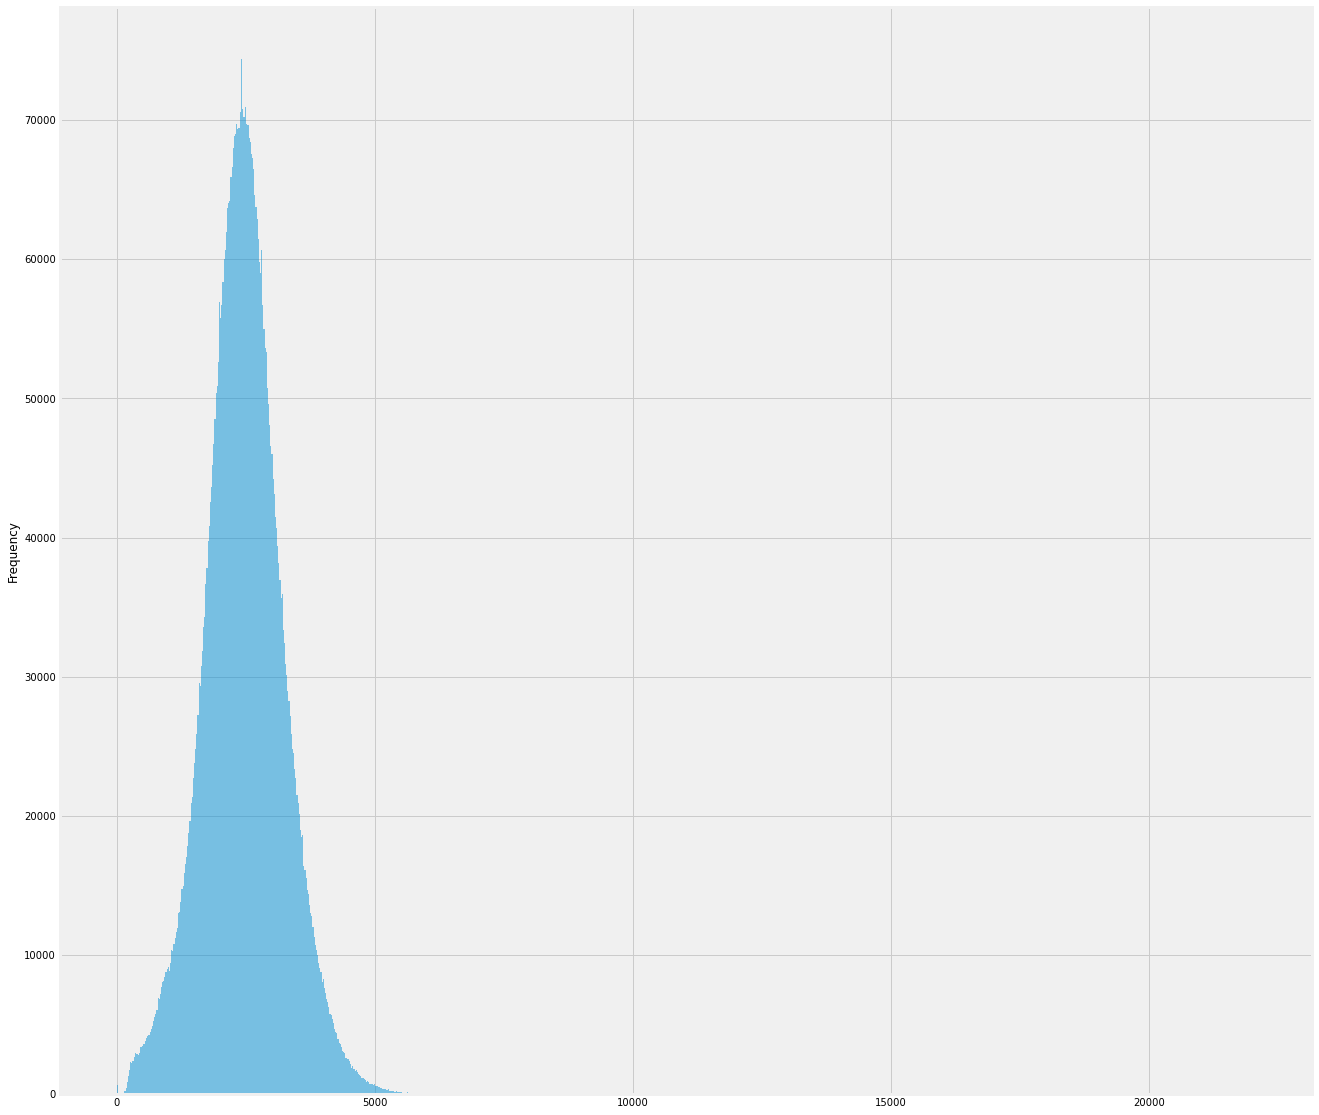

In [23]:
plt.figure(figsize = (20,20))

data_bands['NIR'].plot.hist(bins=1000, alpha = 0.5)

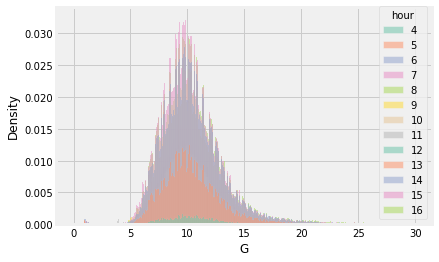

In [24]:
# plt.figure(figsize = (8,8))

# data_bands['hour'].plot.hist(bins=12, alpha = 0.5)

# sns.scatterplot(data=data_bands, x='G', y='hour' )
# plt.show()
sns.histplot(data=data_bands.loc[data_bands["G"]<30], x='G', hue='hour', stat='density', palette = 'Set2')
plt.show()

Curva NIR con perdita


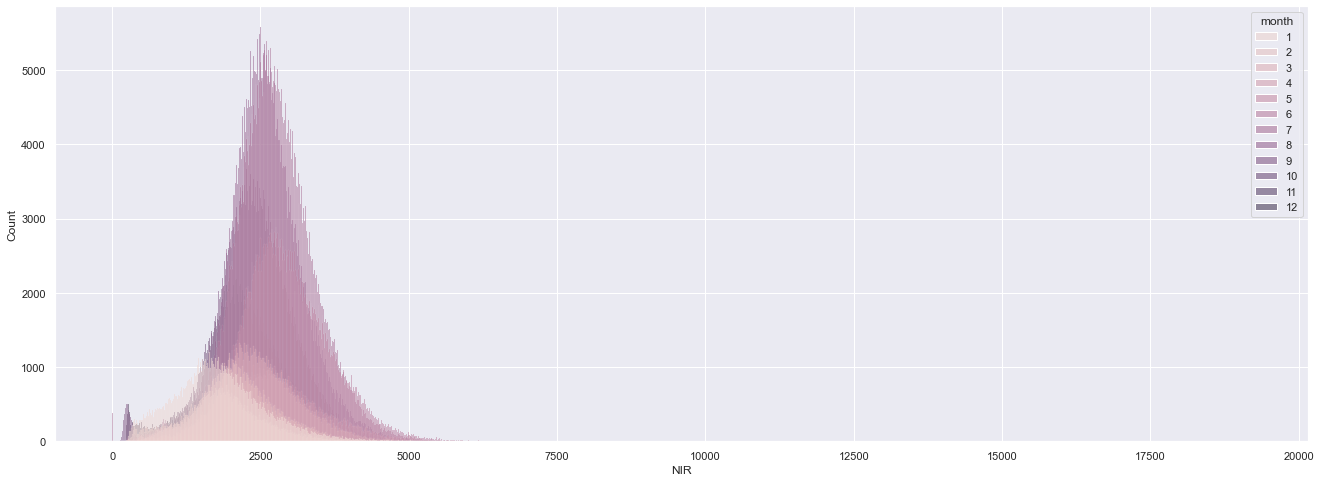

Curva NIR senza perdita


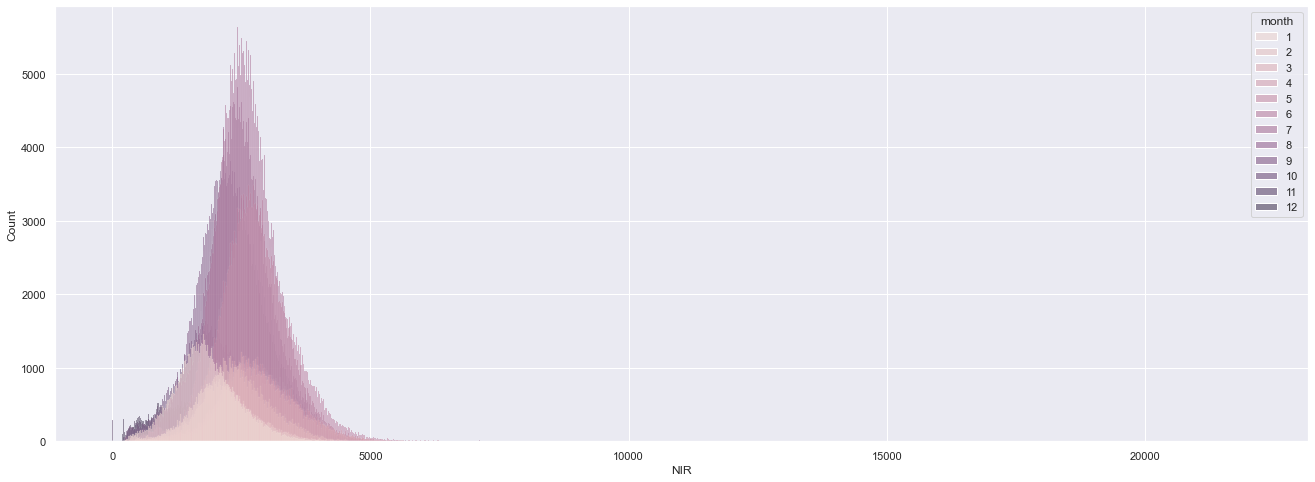

In [25]:
#### Grafico infrarosso
sns.set(rc={'figure.figsize':(20,8)})

# sns.scatterplot(data=data_bands, x="NIR", y="SWIR1", hue="leak")
# plt.show()
# sns.scatterplot(data=data_bands, x="NIR", y="SWIR2", hue="leak")
# plt.show()
print("Curva NIR con perdita")
sns.histplot(data=data_bands[data_bands['leak']==True], x='NIR', hue='month' )
plt.show()
print("Curva NIR senza perdita")
sns.histplot(data=data_bands[data_bands['leak']==False], x='NIR', hue='month' )
plt.show()
# sns.scatterplot(data=data_bands, x="NIR", y="SWIR1", hue="month")

In [44]:
wonum = data_bands['wonum'].iloc[0]

leak_nir = data_bands.loc[data_bands['wonum']==wonum].loc[data_bands['leak']==True]["NIR"]
leak_swir1 = data_bands.loc[data_bands['wonum']==wonum].loc[data_bands['leak']==True]["SWIR1"]
leak_swir2 = data_bands.loc[data_bands['wonum']==wonum].loc[data_bands['leak']==True]["SWIR2"]
noleak_nir = data_bands.loc[data_bands['wonum']==wonum].loc[data_bands['leak']==False]["NIR"]
noleak_swir1 = data_bands.loc[data_bands['wonum']==wonum].loc[data_bands['leak']==False]["SWIR1"]
noleak_swir2 = data_bands.loc[data_bands['wonum']==wonum].loc[data_bands['leak']==False]["SWIR2"]

leak_nir = np.array(leak_nir,dtype='float').reshape(25,25)
leak_nir_norm = (leak_nir-leak_nir.min())/(leak_nir.max()-leak_nir.min())
leak_swir1 = np.array(leak_swir1,dtype='float').reshape(25,25)
leak_swir1_norm = (leak_swir1-leak_swir1.min())/(leak_swir1.max()-leak_swir1.min())
leak_swir2 = np.array(leak_swir2,dtype='float').reshape(25,25)
leak_swir2_norm = (leak_swir2-leak_swir2.min())/(leak_swir2.max()-leak_swir2.min())

noleak_nir = np.array(noleak_nir,dtype='float').reshape(25,25)
noleak_nir_norm = (noleak_nir-noleak_nir.min())/(noleak_nir.max()-noleak_nir.min())
noleak_swir1 = np.array(noleak_swir1,dtype='float').reshape(25,25)
noleak_swir1_norm = (noleak_swir1-noleak_swir1.min())/(noleak_swir1.max()-noleak_swir1.min())
noleak_swir2 = np.array(noleak_swir2,dtype='float').reshape(25,25)
noleak_swir2_norm = (noleak_swir2-noleak_swir2.min())/(noleak_swir2.max()-noleak_swir2.min())

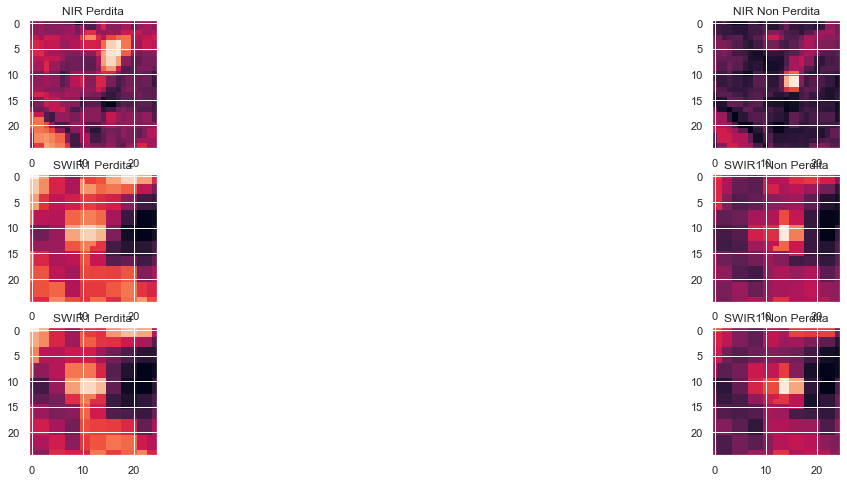

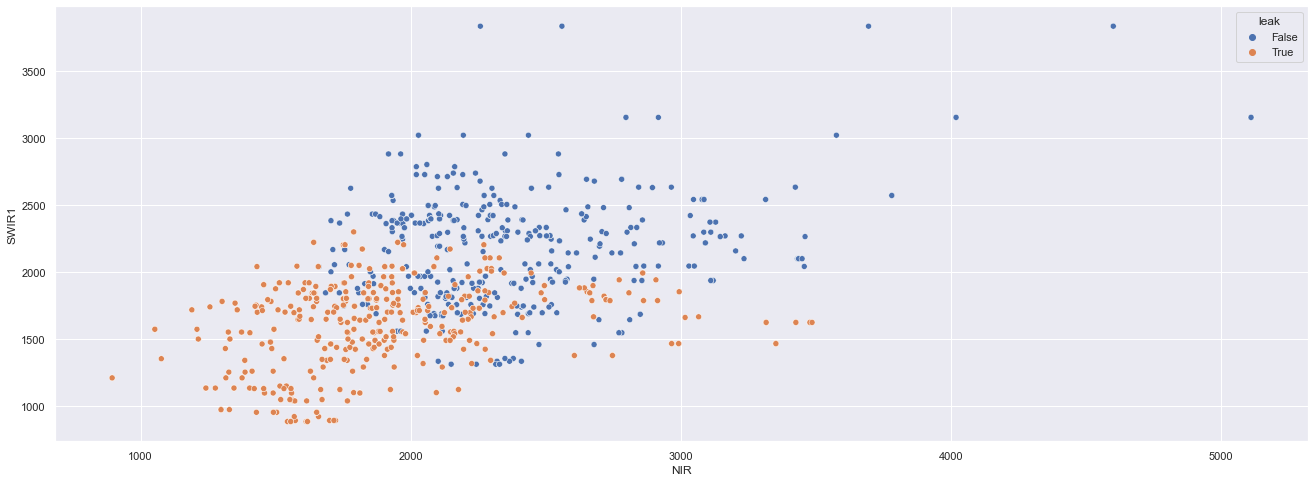

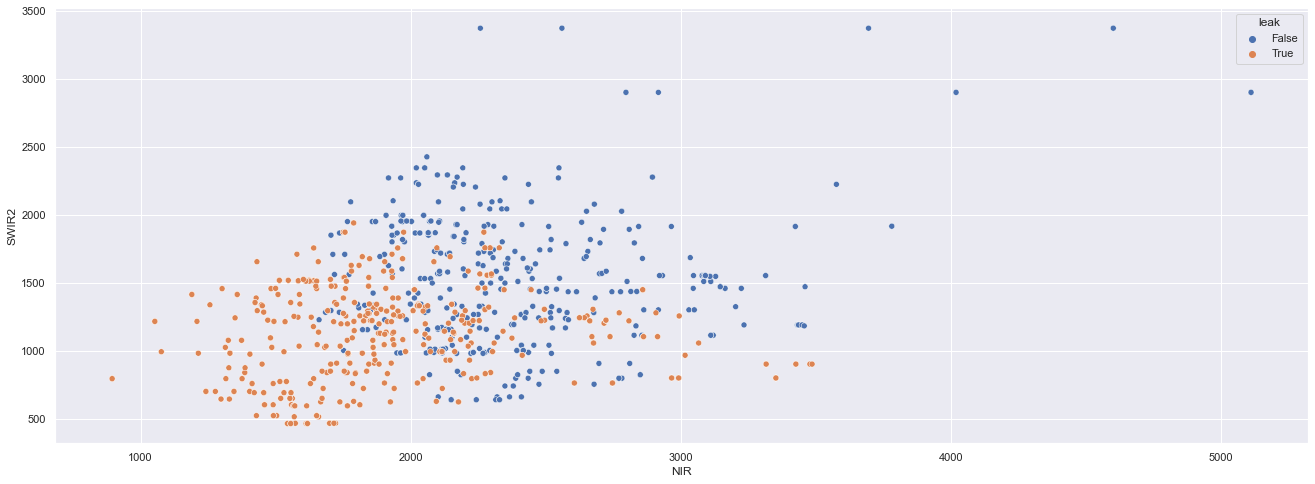

In [45]:
fig, ((nir_leak, nir_noleak), (swir1_leak, swir1_noleak), (swir2_leak, swir2_noleak)) = plt.subplots(3,2)


nir_leak.set_title("NIR Perdita")
nir_leak.imshow(leak_nir_norm)

nir_noleak.set_title("NIR Non Perdita")
nir_noleak.imshow(noleak_nir_norm)

swir1_leak.set_title("SWIR1 Perdita")
swir1_leak.imshow(leak_swir1_norm)

swir1_noleak.set_title("SWIR1 Non Perdita")
swir1_noleak.imshow(noleak_swir1_norm)

swir2_leak.set_title("SWIR1 Perdita")
swir2_leak.imshow(leak_swir2_norm)

swir2_noleak.set_title("SWIR1 Non Perdita")
swir2_noleak.imshow(noleak_swir2_norm)
plt.show()

sns.scatterplot(data=data_bands.loc[data_bands['wonum']==wonum],x="NIR", y="SWIR1", hue="leak")
plt.show()
sns.scatterplot(data=data_bands.loc[data_bands['wonum']==wonum],x="NIR", y="SWIR2", hue="leak")
plt.show()


In [46]:
# shuffle
from sklearn.utils import shuffle
X,y,m,t = shuffle(X,y,m,t,random_state=1337)

In [47]:
# save using hdf5 (so keras can easily load it) and json 
import h5py
h5file = output_dir.joinpath('data.h5')
with h5py.File(h5file, 'w') as h5f:
    h5f.create_dataset('X', data=X)
    h5f.create_dataset('y', data=y)
    h5f.create_dataset('t', data=t)

json.dump(m,open(output_dir.joinpath('data_metadata.json'),'w'))

with open(output_dir.joinpath('readme.md'),'w') as fo:
    fo. write("""
Files:
- ee_ee_scraping_earth_engine_sentinel_2-austin_leaks- cached tiff files
- script_metadata.json - information on scraping script
- data.h5 contains X, y, and t.
    - X: tiff files for each band loaded into an array of shape (Leak, Bands, width, length)
    - y: True for before the leak, False for after
    - t: time before leak (can be negative) in seconds
- data_metadata: array of metadata for each leak in X. Each contain info on leak, image, and image search
    
Loading: 
```py
# load
metadatas = json.load(open('data_metadata.json'))
with h5py.File('data.h5','r') as h5f:
    X2 = h5f['X'][:]
    y2 = h5f['y'][:]
    t2 = h5f['t'][:]
y
```
    """)

In [48]:
# test load
metadatas = json.load(open(output_dir.joinpath('data_metadata.json')))
with h5py.File(output_dir.joinpath('data.h5'),'r') as h5f:
    X2 = h5f['X'][:]
    y2 = h5f['y'][:]
    t2 = h5f['t'][:]
X2.shape, y2, t2, metadatas[0].keys()

((8703, 14, 25, 25),
 array([False,  True, False, ...,  True, False,  True]),
 array([2750181.651,   -5400.21 , 1917024.46 , ...,   17606.107,
        2329345.46 ,   -6550.   ]),
 dict_keys(['image', 'scale', 'crs', 'name', 'distance', 'leak']))

In [49]:
output_dir

Path('C:/Users/tranfa.carmine/Desktop/Satellite/ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S2')